## 2D DG(0) for Godunov's Equation, Roe-Splitting Flux with AB2+FE Time stepping
The 2D Shallow Water Equations are:
\begin{align*} h_t + \nabla\cdot (h\mathbf{u}) &= 0 \\ (h\mathbf{u})_t + \nabla\cdot (h\mathbf{u}\mathbf{u}^T + \frac{1}{2}gh^2 I_2) &=0\end{align*}

where h is the water depth, and $\mathbf{u}$ is the velocity field. In terms of the conserved variables, it may be written in canonical form by defining
$$ \mathbf{q} = \begin{bmatrix} h \\ hu_0 \\ hu_1 \end{bmatrix},\quad \mathbb{F} = \begin{bmatrix} hu_0 & hu_1 \\ hu_0^2+\frac{1}{2}gh^2 & hu_0u_1 \\ hu_1u_0 & hu_1^2+\frac{1}{2}gh^2 \end{bmatrix} $$

And writing $f$ in terms of the conserved variables
$$ \mathbb{F}(\mathbf{q}) = \begin{bmatrix} q_1 & q_2 \\ \frac{q_1^2}{q_0} + \frac{1}{2}gq_0^2 & \frac{q_1q_2}{q_0} \\ \frac{q_1q_2}{q_0} & \frac{q_2^2}{q_0}+\frac{1}{2}gq_0^2  \end{bmatrix}$$

### Spatial Discretization
The canonical form has a 1st order Discrete Galerkin formulation that reads, for each element $\Omega_j$, find $\mathbf{q}\in V^h$, the space of zero order polynomials for each component in $\Omega_j$ and zero elsewhere, such that
$$ \frac{\partial}{\partial t}(\mathbf{q},v)_{\Omega_j} + \int_{\partial\Omega_j} v(\tilde{\mathbb{F}}(\mathbf{q}_i,\mathbf{q}_e) - \mathbb{F}(\mathbf{q}_i))\cdot\mathbf{n}\ ds + (\nabla \cdot \mathbb{F}(\mathbf{q}),v)_{\Omega_j} = 0 $$
for all $v\in V^h$. Where the $(\cdot,\cdot)_\Omega$ notation has been used to denote an integral over $\Omega$. Noting that taking the space of zero order polynomials reduces to taking $v=1$ for all $\Omega_j$, $\mathbf{q}=\mathbf{q}^h_j$, which makes the entries of $\mathbb{F}(\mathbf{q}^h_j)$ constant, so the formulation becomes

$$ |\Omega_j|\frac{\partial}{\partial t}\mathbf{q} + \int_{\partial\Omega_j} (\tilde{\mathbb{F}}(\mathbf{q}_i,\mathbf{q}_e) - \mathbb{F}(\mathbf{q}_i))\cdot\mathbf{n}\ ds = 0 $$

where $|\Omega_j|$ is the size of the element $\Omega_j$. Additionally, as the fluxes are constant along each edge of $\Omega_j$, the boundary integral can be turned into a sum over the edges giving
$$ \frac{\partial}{\partial t}\mathbf{q}+\sum_l \frac{|\partial\Omega_{jl}|}{|\Omega_j|}(\tilde{\mathbb{F}}(\mathbf{q}_i,\mathbf{q}_{e,l})-\mathbb{F}(\mathbf{q}_i))\cdot\mathbf{n}_l = 0 $$

To simplify the implementation of the fluxes, the edge normal vector $\mathbf{n}_l$ is split into $\mathbf{n}_{0,l}$, and $\mathbf{n}_{1,l}$ such that $\mathbf{n}_l = [n_{0,l},0]^T + [0, n_{1,l}]$, then the flux matrix becomes two vector fluxes, the columns of $\mathbb{F}$, and the required Jacobians are easily computed. Explicitly,
$$ \mathbb{F}(\mathbf{q})\cdot\mathbf{n}_{0,l} = n_{0,l}\mathbf{f}_0(\mathbf{q}) = n_{0,l}\begin{bmatrix} q_1 \\ \frac{q_1^2}{q_0} + \frac{1}{2}gq_0^2 \\ \frac{q_1q_2}{q_0} \end{bmatrix},\quad \mathbb{F}(\mathbf{q})\cdot\mathbf{n}_{1,l} = n_{1,l}\mathbf{f}_1(\mathbf{q}) = n_{1,l}\begin{bmatrix} q_2 \\ \frac{q_1q_2}{q_0} \\ \frac{q_2^2}{q_0} + \frac{1}{2}gq_0^2 \end{bmatrix} $$
Hence, the formulation is
$$\boxed{ \frac{\partial}{\partial t}\mathbf{q} + \sum_l \frac{|\partial\Omega_{jl}|}{|\Omega_j|}\left[ (\tilde{\mathbf{f}}_0(\mathbf{q}_i,\mathbf{q}_{e,l})-\mathbf{f}_0(\mathbf{q}_i))n_{0,l} + (\tilde{\mathbf{f}}_1(\mathbf{q}_i,\mathbf{q}_{e,l})-\mathbf{f}_1(\mathbf{q}_i))n_{1,l} \right] = 0\ }$$

#### On the Numerical flux functions
The Jacobian matrices corresponding to the $\mathbf{f}_0$ and $\mathbf{f}_1$ fluxes are required and are:
$$ \mathbb{J}(\mathbf{f}_0) = \begin{bmatrix} 0 & 1 & 0 \\ \frac{-q_1^2}{q_0^2}+gq_0 & \frac{2q_1}{q_0} & 0 \\ \frac{-q_1q_2}{q_0^2} & \frac{q_2}{q_0} & \frac{q_1}{q_0}  \end{bmatrix},\quad  \mathbb{J}(\mathbf{f}_1) = \begin{bmatrix} 0 & 0 & 1 \\ \frac{-q_1q_2}{q_0^2} & \frac{q_2}{q_0} & \frac{q_1}{q_0} \\ \frac{-q_2^2}{q_0^2}+gq_0 & 0 & \frac{2q_2}{q_0} \end{bmatrix}$$

which have eigenvalues:
$$ \lambda_{0,0} = \frac{q_1}{q_0},\quad \lambda_{0,1} = \frac{q_1}{q_0}-\sqrt{gq_0},\quad \lambda_{0,2} = \frac{q_1}{q_0}+\sqrt{gq_0},\quad \lambda_{1,0} = \frac{q_2}{q_0},\quad \lambda_{1,1} = \frac{q_2}{q_0}-\sqrt{gq_0},\quad \lambda_{1,2} = \frac{q_2}{q_0} + \sqrt{gq_0}$$
are the corresponding right eigenvectors:
$$ \mathbf{k}_{0,0} = [0,0,1]^T,\quad \mathbf{k}_{0,1} = \left[1,\frac{q_1}{q_0}-\sqrt{gq_0},\frac{q_2}{q_0}\right]^T,\quad \mathbf{k}_{0,2} = \left[1,\frac{q_1}{q_0}+\sqrt{gq_0},\frac{q_2}{q_0}\right]^T,\quad \mathbf{k}_{1,0} = [0,1,0]^T,\quad \mathbf{k}_{1,1} = \left[ 1, \frac{q_1}{q_0}, \frac{q_2}{q_0}-\sqrt{gq_0} \right]^T,\quad \mathbf{k}_{1,2} = \left[ 1, \frac{q_1}{q_0}, \frac{q_2}{q_0}+\sqrt{gq_0} \right]^T $$

Recalling the Roe-splitting flux used in the 1D shallow water equatiions,
$$\boxed{ \tilde{\mathbf{f}}(\mathbf{q}^-,\mathbf{q}^+) = \frac{1}{2}\left(\mathbf{f}(\mathbf{q}^-)+\mathbf{f}(\mathbf{q}^+) - R|\Lambda|L(\mathbf{q}^--\mathbf{q}^+)\right)}$$
with the Jacobian and eigendecomposition being evaluated at the average of $\mathbf{q}^-$ and $\mathbf{q}^+$.

Hence, the $R$ matrices are
$$ R_0 = \begin{bmatrix} 0 & 1 & 1 \\ 0 & \frac{q_1}{q_0} - \sqrt{gq_0} & \frac{q_1}{q_0} + \sqrt{gq_0} \\ 1 & \frac{q_2}{q_0} & \frac{q_2}{q_0} \end{bmatrix},\quad R_1 = \begin{bmatrix} 0 & 1 & 1 \\ 1 & \frac{q_1}{q_0} & \frac{q_1}{q_0} \\ 0 & \frac{q_2}{q_0}-\sqrt{gq_0} & \frac{q_2}{q_0} + \sqrt{gq_0} \end{bmatrix} $$

and the $L$ matrices are the inverse of the $R$ matrices, that is
$$ L_0 = \begin{bmatrix} \frac{-q_2}{q_0} & 0 & 1 \\ \frac{1}{2}\left(1+\frac{q_1}{q_0\sqrt{gq_0}}\right) & \frac{-1}{2\sqrt{gq_0}} & 0 \\ \frac{1}{2}\left(1-\frac{q_1}{q_0\sqrt{gq_0}}\right) & \frac{1}{2\sqrt{gq_0}} & 0 \end{bmatrix},\quad L_1 = \begin{bmatrix} \frac{-q_1}{q_0} & 1 & 0 \\ \frac{1}{2}\left(1+\frac{q_2}{q_0\sqrt{gq_0}}\right) & 0 & \frac{-1}{2\sqrt{gq_0}} \\ \frac{1}{2}\left(1-\frac{q_2}{q_0\sqrt{gq_0}}\right) & 0 & \frac{1}{2\sqrt{gq_0}}\end{bmatrix} $$

### Temporal Discretization
The same temporal discretization as in the scalar conservation case (but vectorized) is used.

To timestep an equation of the form $\partial_t \mathbf{q} = \mathbf{F}(\mathbf{q})$, the Second-order Adams Bashforth Method is used, that is
$$ \boxed{\mathbf{q}^{n+1} = \mathbf{q}^n + \frac{\Delta t}{2}\left( 3\mathbf{F}(\mathbf{q}^n) - \mathbf{F}(\mathbf{q}^{n-1}) \right) }$$
Which is a 2-step method, and hence requires a single second order step, which can be done with a single Forward Euler step
$$ \mathbf{q}^1 = \mathbf{q}^0 + \Delta t\mathbf{F}(\mathbf{q}^0) $$

### Implementation
Since the equations have been extended to the 2D case, the mesh must be a 2d construction. The following must be kept track of:
- cell centers and vertices, area, and edge lengths
- $\mathbf{q}^k$ (solution at time-step k), time-derivatives $\mathbf{F}^k$, $\mathbf{F}^{k-1}$.

For simplicity, consider a rectangle (square) of side lengths $l$ centered at $(0,0)$. The square can be tessellated with squares of sidelength $h$ centered at $\mathbf{x}_{ij}$, with $h$ chosen such that $N+1$ points partition the x and y axis. Any boundary conditions can be imposed by extending the domain one cell around the outside. For the square, this results in a $N+3$ by $N+3$ grid.

In [2]:
### Imports
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from domain import Mesh, Cell2d

### Parameters
g = 9.81
l = 1
h = 0.2

### Spatial Discretization
N = int(2*l/h)
x = np.linspace(-l-h,l+h,N+3)
y = np.linspace(-l-h,l+h,N+3)
cells = []
for xi in x:
    for yj in y:
        cells.append( Cell2d( np.array([xi,yj]),np.array([[xi-h/2,yj-h/2],[xi+h/2,yj-h/2],
                                                          [xi+h/2,yj+h/2],[xi-h/2,yj+h/2]]) ) )
cellsx = []
for xi in x:
    cellsx.append( Cell2d( np.array([xi,0]), np.array([[xi-h/2,-h/2],[xi+h/2,-h/2],
                                                          [xi+h/2,h/2],[xi-h/2,h/2]]) ) )
msh = Mesh(2, cells)

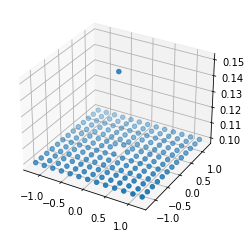

In [3]:
# Initial Condition
def IC(x):
    return np.array([0.05*np.exp(-100*(x[0]**2+x[1]**2))+.1, 0.,0.])
# def IC(x):
#     if x[0] > 0:
#         return np.array([3.,0.,0.])
#     return np.array([6.,0.,0.])
msh.impose_IC(IC)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter([x[0] for x in msh.x], [x[1] for x in msh.x], ([u[0] for u in msh.u]))


### Flux Definition
def f0(q): # x-flux function
    return np.array([q[1], q[1]**2/q[0] + 0.5*g*q[0]**2, q[1]*q[2]/q[0]])
def f1(q): # y-flux function
    return np.array([q[2], q[1]*q[2]/q[0], q[2]**2/q[0]+0.5*g*q[0]**2])

def numf0(qm,qp): # numerical x-flux function
    q = 0.5*(qm+qp)
    R = np.array([[0,1,1],
                  [0,q[1]/q[0] - np.sqrt(g*q[0]),q[1]/q[0] + np.sqrt(g*q[0])],
                  [1,q[2]/q[0],q[2]/q[0]]])
    L = np.array([[-q[2]/q[0], 0, 1],
                  [0.5*(1+q[1]/(q[0]*np.sqrt(g*q[0]))), -1/(2*np.sqrt(g*q[0])), 0],
                  [0.5*(1-q[1]/(q[0]*np.sqrt(g*q[0]))), 1/(2*np.sqrt(g*q[0])), 0]])
    Lm = np.diag(np.array([np.abs(q[1]/q[0]),
                          np.abs(q[1]/q[0]-np.sqrt(g*q[0])),
                          np.abs(q[1]/q[0]+np.sqrt(g*q[0]))]))
    return 0.5*( f0(qm) + f0(qp) - np.matmul(np.matmul(np.matmul(R,Lm),L),qm-qp) )
def numf1(qm,qp): # numerical y-flux function
    q = 0.5*(qm+qp)
    R = np.array([[0, 1, 1],
                  [1, q[1]/q[0], q[1]/q[0]],
                  [0, q[2]/q[0]-np.sqrt(g*q[0]), q[2]/q[0]+np.sqrt(g*q[0])]])
    L = np.array([[-q[1]/q[0], 1, 0],
                  [0.5*(1+q[2]/(q[0]*np.sqrt(g*q[0]))), 0, -1/(2*np.sqrt(g*q[0]))],
                  [0.5*(1-q[2]/(q[0]*np.sqrt(g*q[0]))), 0, 1/(2*np.sqrt(g*q[0]))]])
    Lm = np.diag( np.array([np.abs(q[2]/q[0]),
                            np.abs(q[2]/q[0]-np.sqrt(g*q[0])),
                            np.abs(q[2]/q[0]+np.sqrt(g*q[0]))]) )
    return 0.5*( f1(qm) + f1(qp) - np.matmul(np.matmul(np.matmul(R,Lm),L),qm-qp) )

# Semi-discrete form
def F(cell): # semi-discrete form for an individual interior cell
    F = 0
    Omega = cell.size
    for l in range(len(cell.nbrs)):
        delOmega = np.linalg.norm(cell.edges[l])
        n = cell.nbrnormal[l]
        if n[0] < 0:
            F -= (delOmega/Omega) * (numf0(cell.u,cell.nbrs[l].u)-f0(cell.u))*n[0]
        elif n[0] > 0:
            F -= (delOmega/Omega) * (numf0(cell.nbrs[l].u,cell.u)-f0(cell.u))*n[0]
        if n[1] < 0:
            F -= (delOmega/Omega) * (numf1(cell.u,cell.nbrs[l].u)-f1(cell.u))*n[1]
        elif n[1] > 0:
            F -= (delOmega/Omega) * (numf1(cell.nbrs[l].u,cell.u)-f1(cell.u))*n[1]
    return F

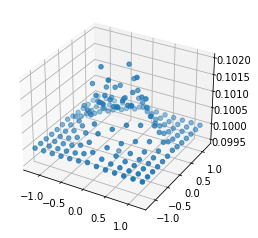

In [ ]:
### Time Stepping
# Timing Parameters
dt = h/200
T = 0.4

def ab2(u,Fn1,Fn0): # 2nd Order Adams-Bashforth
    return u + 0.5*dt*(3*Fn1-Fn0)

def fe(u,Fn0): # Forward Euler
    return u + dt*Fn0

# Initial Time step so that AB2 can be used
for cell in msh.cells:
    cell.F0 = F(cell)
    cell.u = fe(cell.u, cell.F0)
msh.retrieve_u()

# Time stepping with AB2
t = dt
while t < T:
    clear_output(wait=True)
    t += dt
    for cell in msh.cells:
        cell.F1 = F(cell)
        u1 = ab2(cell.u, cell.F1, cell.F0)
        cell.F0 = cell.F1
        cell.u = u1
    msh.retrieve_u()

    # Plot result
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.scatter([x[0] for x in msh.x], [x[1] for x in msh.x], ([u[0] for u in msh.u]))
    plt.show()